In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")

import common_functions as cf

## Import Data

In [13]:
df_all = pd.read_pickle("merged_df.pkl")

# Feature engineering (basic)

In [14]:
df_fe = cf.fe_basic_features(df_all)

# Feature engineering (Rolling)
rolling function takes an amount of directly preceding values to generate stuff like mean, median etc. So for my later input data, I don't need anything else than a set of preceding motion data.

In [15]:
ROLL_STEPS = 100

In [16]:
roll_df =  cf.fe_roll_features(df_fe,ROLL_STEPS)

## Data Splitting(Test/train)

In [19]:
train_df_roll,test_df_roll = cf.data_split_TrainTest(roll_df)

## Preprocess (Normalizing)

In [21]:
from sklearn.preprocessing import StandardScaler

for act_num in train_df_roll.action_num.unique():
    std = StandardScaler().set_output(transform='pandas')
    std.fit(train_df_roll.loc[train_df_roll.action_num == act_num,:"rotR_z_rmed"])
    train_df_roll.loc[train_df_roll.action_num == act_num,:"rotR_z_rmed"] = std.transform(train_df_roll.loc[train_df_roll.action_num == act_num,:"rotR_z_rmed"])


for act_num in test_df_roll.action_num.unique():
    std = StandardScaler().set_output(transform='pandas')
    std.fit(test_df_roll.loc[test_df_roll.action_num == act_num,:"rotR_z_rmed"])
    test_df_roll.loc[test_df_roll.action_num == act_num,:"rotR_z_rmed"] = std.transform(test_df_roll.loc[test_df_roll.action_num == act_num,:"rotR_z_rmed"])

In [25]:
#X_train_roll = cf.pre_normalize_tanh(X_train_roll)
#X_test_roll = cf.pre_normalize_tanh(X_test_roll)

## Modeling

### Split Data (Feature/Label)

In [23]:
X_train_roll,y_train_roll = cf.data_split_FeatLabel(train_df_roll)
X_test_roll,y_test_roll = cf.data_split_FeatLabel(test_df_roll)

### Neurel Network

In [28]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


import tensorflow as tf
import sklearn
tf.random.set_seed(20) # to fix the randomization
import numpy as np
np.random.seed(20)# to fix the randomizationin sklearn
sklearn.random.seed(1)

In [29]:
input_dim = X_train_roll.shape[1]
cnn = Sequential()
cnn.add(Dense(80, input_dim=input_dim, activation='relu'))
cnn.add(Dropout(rate =0.2)) # drop some of the neurals in the back prop. analysis to avoid overfitting
cnn.add(BatchNormalization())
cnn.add(Dense(40, activation='relu'))
cnn.add(Dropout(rate =0.5))
cnn.add(BatchNormalization())
cnn.add(Dense(20, activation='relu'))
cnn.add(Dropout(rate =0.2))
cnn.add(BatchNormalization())
cnn.add(Dense(1, activation='sigmoid'))

In [30]:
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                2320      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 40)               160       
 hNormalization)                                        

In [31]:
opt = keras.optimizers.Adam(learning_rate=0.02)

cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

X_train, val_X, y_train, val_y = train_test_split(X_train_roll, y_train_roll, shuffle=True,test_size=0.2 )

In [32]:
X_train_arr = np.asarray(X_train_roll)
y_train_arr = np.asarray(y_train_roll)
X_test_arr = np.asarray(X_test_roll)
y_test_arr = np.asarray(y_test_roll)
val_X =  np.asarray(val_X)
val_y =  np.asarray(val_y)

In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [34]:
history = cnn.fit(X_train_arr, y_train_arr, epochs=100, batch_size=250,callbacks=[es,mc]
                  , validation_data=(val_X,val_y)
                  )


Epoch 1/100
115/117 [============================>.] - ETA: 0s - loss: 0.4360 - accuracy: 0.7902
Epoch 1: val_accuracy improved from -inf to 0.93081, saving model to best_model.h5
117/117 [==============================] - 8s 22ms/step - loss: 0.4335 - accuracy: 0.7917 - val_loss: 0.1772 - val_accuracy: 0.9308
Epoch 2/100
115/117 [============================>.] - ETA: 0s - loss: 0.2526 - accuracy: 0.8967
Epoch 2: val_accuracy improved from 0.93081 to 0.94759, saving model to best_model.h5
117/117 [==============================] - 2s 21ms/step - loss: 0.2524 - accuracy: 0.8967 - val_loss: 0.1245 - val_accuracy: 0.9476
Epoch 3/100
112/117 [===========================>..] - ETA: 0s - loss: 0.1926 - accuracy: 0.9250
Epoch 3: val_accuracy improved from 0.94759 to 0.97791, saving model to best_model.h5
117/117 [==============================] - 1s 12ms/step - loss: 0.1927 - accuracy: 0.9250 - val_loss: 0.0738 - val_accuracy: 0.9779
Epoch 4/100
115/117 [============================>.] - ETA

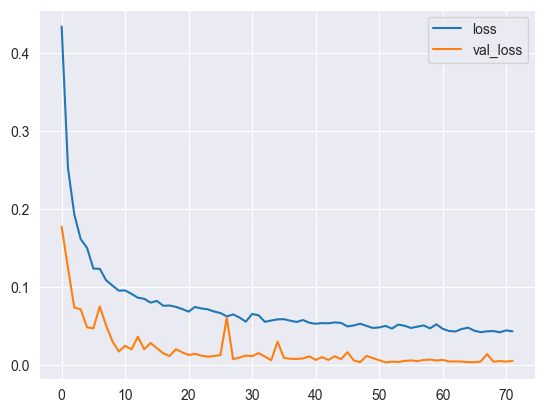

In [35]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss',"val_loss"]].plot()
plt.show()

#### Evaluation

- Evaluate best model which was monitored and saved

In [36]:
best_saved_model = load_model('best_model.h5')
_, train_acc = best_saved_model.evaluate(X_train_arr, y_train_arr, verbose=0)
_, test_acc = best_saved_model.evaluate(X_test_arr, y_test_arr, verbose=0)
print('Train: %.2f, Test: %.2f' % (train_acc*100, test_acc*100))

Train: 99.98, Test: 87.28


In [37]:

best_model_predictions = best_saved_model.predict(X_test_arr)
mae = round(mean_absolute_error(y_test_roll, best_model_predictions),3)
print("mean absolute error is",mae)

745/745 [==============================] - 4s 4ms/step
mean absolute error is 0.134


In [38]:
# convert predicted label rom analog to binary value
bin_best_model_predictions=[]
for val in best_model_predictions:
    if val >=0.5:
        bin_best_model_predictions.append(1)
    else:
        bin_best_model_predictions.append(0)

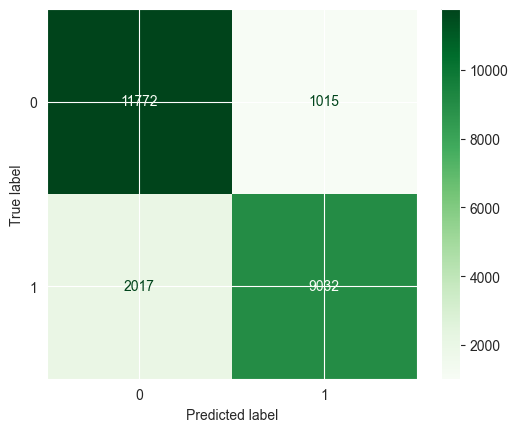

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(bin_best_model_predictions, y_test_roll)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
conf_mat_disp.plot(cmap='Greens')
plt.show()